In [59]:
import baccoemu
import chainconsumer
import dynesty
import gc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

import emcee
import os
import pandas as pd
import time

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
#import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
import generate_emuPks as genP

from momentnetworks import demo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

48 CPUs


In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

#N_threads = sbi_tools.set_N_threads(6)

### Load baccoemu P(k) data

In [5]:
tag_emuPk = '_2param'

fn_emuPk = f'../data/emuPks/emuPks{tag_emuPk}.npy'
fn_emuPk_params = f'../data/emuPks/emuPks_params{tag_emuPk}.txt'
fn_emuk = f'../data/emuPks/emuPks_k{tag_emuPk}.txt'

Pk = np.load(fn_emuPk)
theta = np.genfromtxt(fn_emuPk_params, delimiter=',', names=True)
param_names = theta.dtype.names
# from tuples to 2d array
theta = np.array([list(tup) for tup in theta])
kk = np.genfromtxt(fn_emuk)

In [6]:
mask = np.full(len(kk), True)

In [7]:
print(Pk.shape, theta.shape)

(1000, 30) (1000, 2)


In [8]:
# if wan't to run on a subset, edit n_samples here (max=1000 right now)
n_samples = 1000 
Pk = Pk[:n_samples]
theta = theta[:n_samples]

In [9]:
n_tot = theta.shape[0]
n_params = theta.shape[1]
n_dim = Pk.shape[1]
print(n_tot, n_params, n_dim)

1000 2 30


Plot P(k) data:

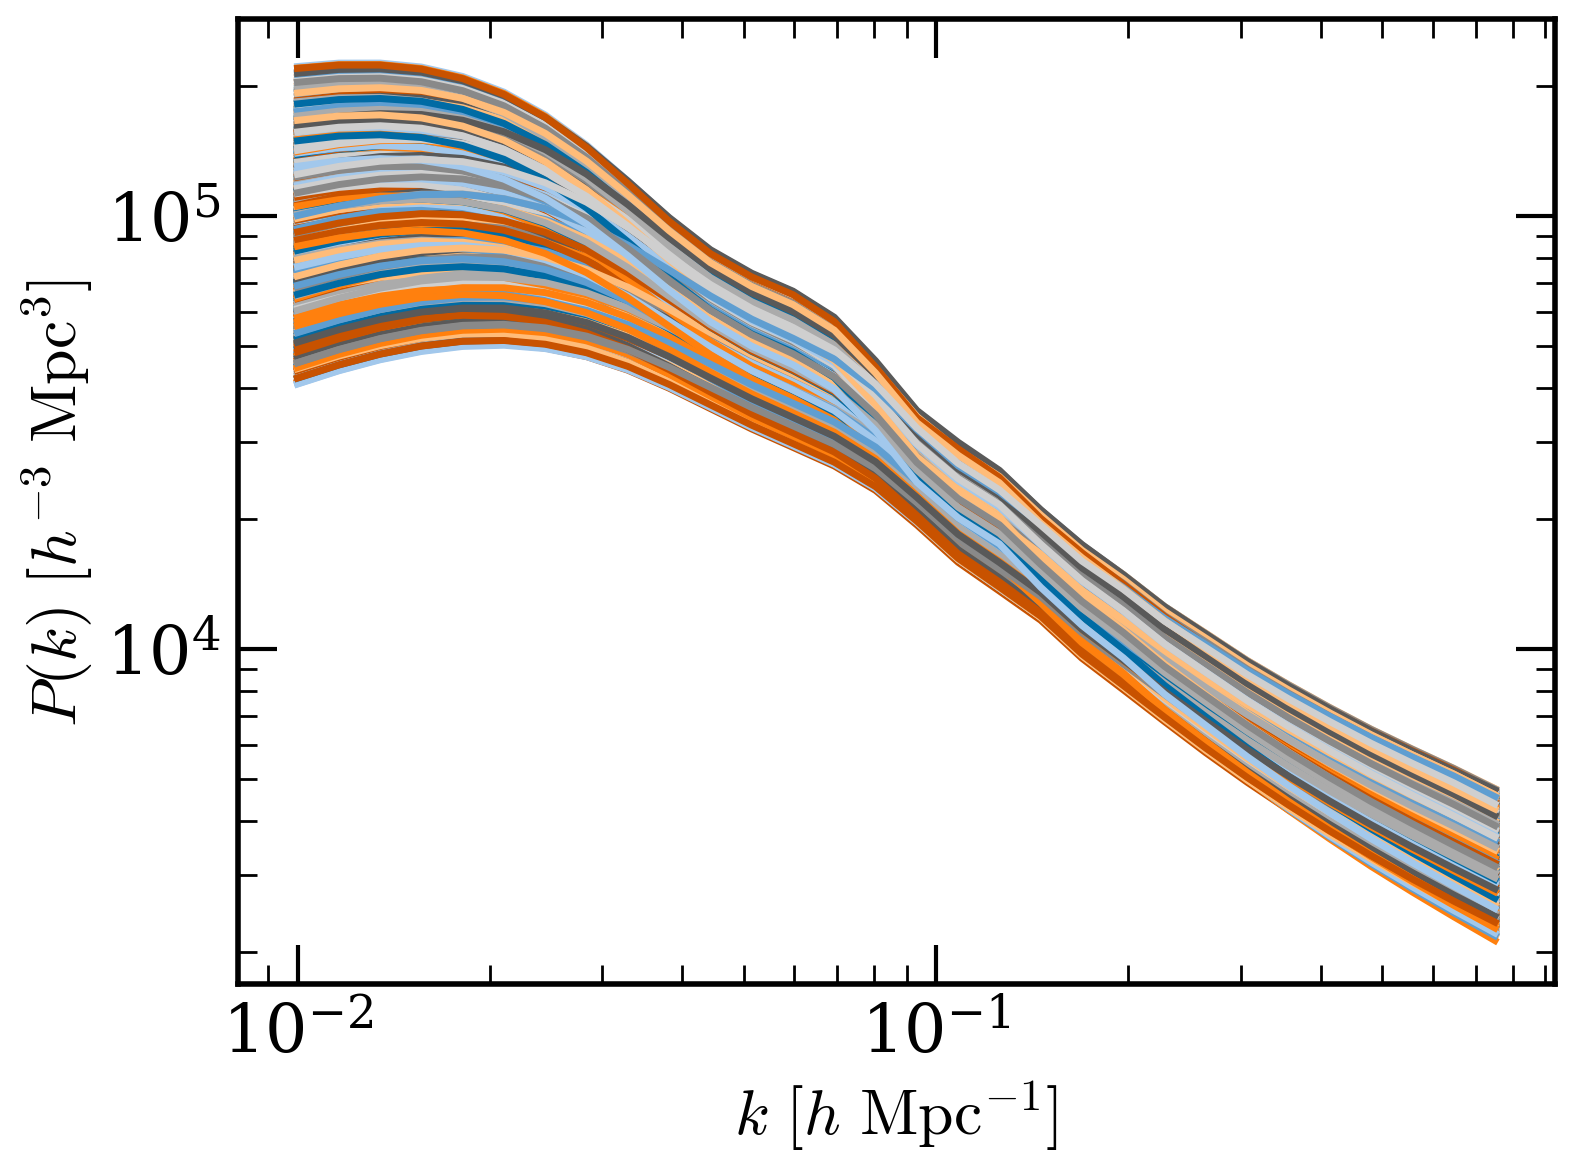

In [10]:
fig, ax = mpl.pyplot.subplots(figsize=(8, 6))
for iLH in range(n_tot):
    ax.loglog(kk[mask], Pk[iLH][mask])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [11]:
#n_biasmodels = len(biases_vec)
n_biasmodels = 0
n_cosmos = n_params
print(n_biasmodels, n_cosmos)

0 2


Split into train-val-test

In [12]:
p_train, p_test = 0.8, 0.1
p_val = 1-p_train-p_test
train_split = int(theta.shape[0]*p_train)
test_split = int(theta.shape[0]*(1-p_test))
#train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_split]
theta_val = theta[train_split:test_split]
theta_test = theta[test_split:]
print(theta_train.shape, theta_val.shape, theta_test.shape)

Pk_train = Pk[:train_split]
Pk_val = Pk[train_split:test_split]
Pk_test = Pk[test_split:]

mask = np.all(Pk_train>0, axis=0)
Pk_train = Pk_train[:,mask]
Pk_val = Pk_val[:,mask]
Pk_test = Pk_test[:,mask]
k = kk[mask]

(800, 2) (100, 2) (100, 2)


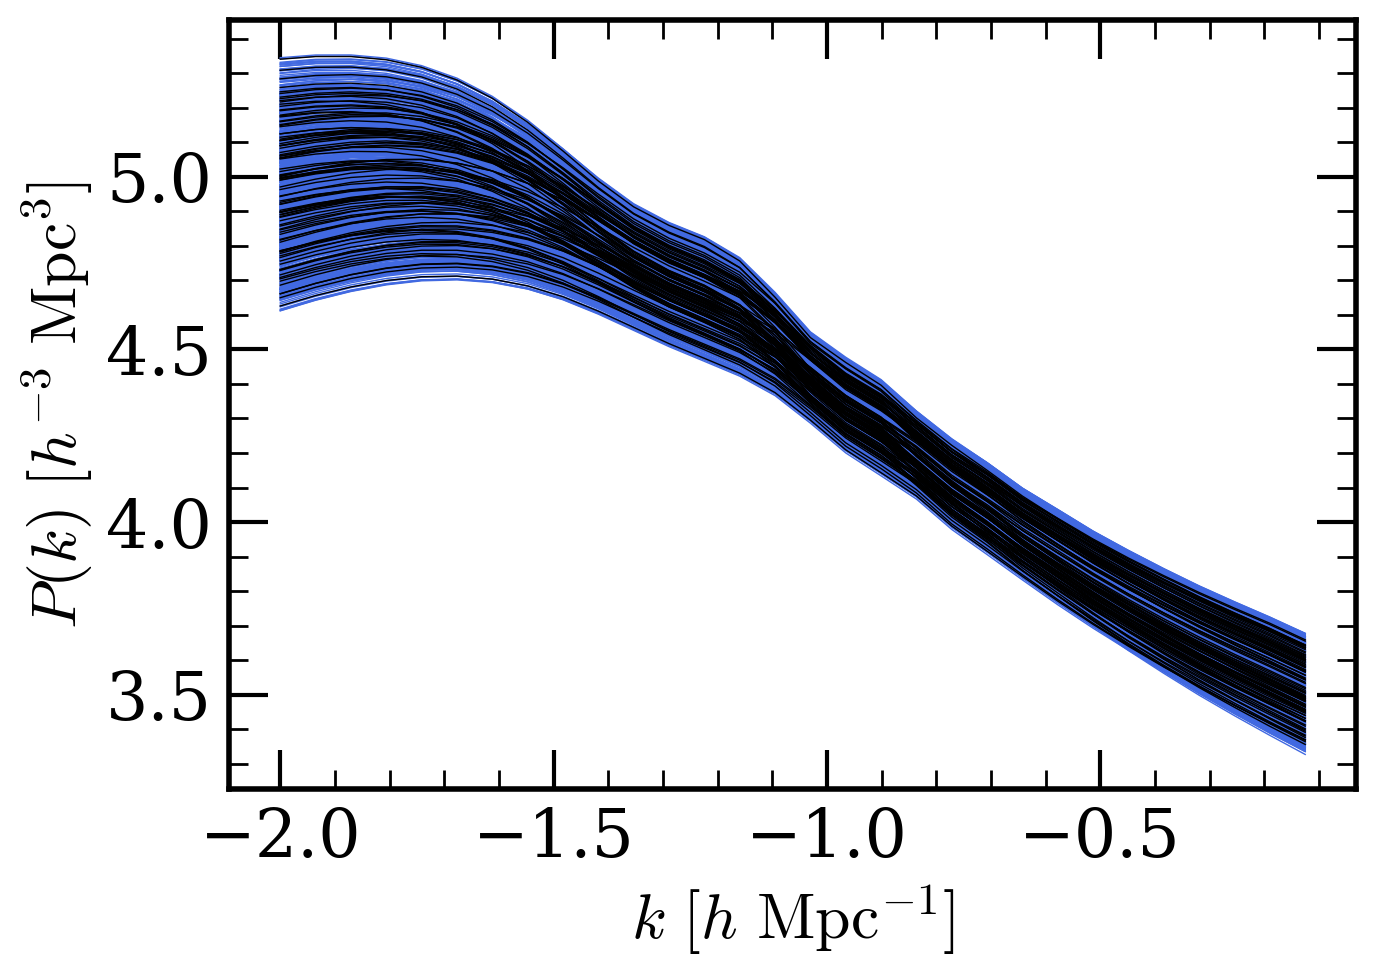

In [13]:
fig, ax = mpl.pyplot.subplots(1,1, figsize=(7,5))
fontsize = 24
fontsize1 = 18

alpha = 1

tmp_Pk_plot = Pk_train
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='royalblue', alpha=alpha, lw=0.5, label='training set')

tmp_Pk_plot = Pk_test
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='k', alpha=alpha, lw=0.5, label='test set')
    
ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [14]:
dict_bounds = {}
for pp, param_name in enumerate(param_names):
    dict_bounds[param_name] = [np.min(theta[:,pp]), np.max(theta[:,pp])]

In [15]:
class Scaler:

    def __init__(self):
          pass
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train)
        self.x_train_max = np.max(x_train)
           
    def scale(self, x):
        log_x = np.log10(x)
        log_x_norm = (log_x - np.log10(self.x_train_min)) / (np.log10(self.x_train_max) - np.log10(self.x_train_min))
        return log_x_norm
    
    def unscale(self, x_scaled):
        x = x_scaled * (np.log10(self.x_train_max) - np.log10(self.x_train_min)) + np.log10(self.x_train_min)
        return 10**x  

In [16]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_val_scaled = scaler.scale(Pk_val)
Pk_test_scaled = scaler.scale(Pk_test)

In [17]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

2122.694510138306 225463.68122927166
0.0 1.0
2269.2450216884245 223067.1168970354
0.014309569967360158 0.9977094736703725


In [18]:
print(Pk_train.shape)
print(theta_train.shape)
print(n_params)

(800, 30)
(800, 2)
2


### Set up and run Moment Network model

Following demos at https://github.com/NiallJeffrey/MomentNetworks/tree/master

In [19]:
model_instance = demo.simple_leaky(n_dim, n_params, learning_rate=1e-4) 
regression = model_instance.model() 

30


2024-02-16 12:05:08.351820: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                1860      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 30)                0     

In [20]:
print(theta_train.shape, Pk_train.shape)
print(theta_val.shape, Pk_val.shape)

(800, 2) (800, 30)
(100, 2) (100, 30)


Train initial model (basic MLP), as usual, on labeled data

In [21]:
history = regression.fit(Pk_train_scaled, theta_train,
                         epochs=200, batch_size=32, shuffle=True,
                         validation_data=(Pk_val_scaled, theta_val))

Epoch 1/200
25/25 [==============================] - 2s 30ms/step - loss: 0.2955 - val_loss: 0.1093
Epoch 2/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0283 - val_loss: 0.0072
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/200
25/25 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/200
25/25 [==============================] - 1s 28ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/200
25/25 [==============================] - 1s 25ms/step - loss: 0.0026 - val_loss: 0.0025
Epoc

In [22]:
#predicted_mean = regression.predict(np.atleast_2d(Pk_train_scaled)) # maybe should be train & val??

Get means and residuals

In [23]:
training_var_unknown_mean = (theta_train-regression.predict(np.atleast_2d(Pk_train_scaled)))**2.
training_var_unknown_mean = np.hstack([training_var_unknown_mean,
                                      np.atleast_2d((theta_train[:,0]-regression.predict(np.atleast_2d(Pk_train_scaled))[:,0])*
                                      (theta_train[:,1]-regression.predict(np.atleast_2d(Pk_train_scaled))[:,1])).T])
print(training_var_unknown_mean.shape)

training_var_unknown_mean_val = (theta_val-regression.predict(np.atleast_2d(Pk_val_scaled)))**2.
training_var_unknown_mean_val = np.hstack([training_var_unknown_mean_val,
                                      np.atleast_2d((theta_val[:,0]-regression.predict(np.atleast_2d(Pk_val_scaled))[:,0])*
                                      (theta_val[:,1]-regression.predict(np.atleast_2d(Pk_val_scaled))[:,1])).T])

25/25 [==============================] - 0s 4ms/step
(800, 3)
4/4 [==============================] - 0s 11ms/step


Set up and train model on the residuals

In [24]:
model_instance = demo.simple_leaky(n_dim, 3, learning_rate=1e-3)
regression_var_unknown_mean = model_instance.model()

30
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 60)                1860      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1830      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30)                0

In [25]:
history = regression_var_unknown_mean.fit(Pk_train_scaled,
                                          training_var_unknown_mean,
                                          epochs=200, batch_size=32, shuffle=True,
                                          validation_data = (Pk_val_scaled,
                                                             training_var_unknown_mean_val))

Epoch 1/200
25/25 [==============================] - 1s 31ms/step - loss: 6.7424e-07 - val_loss: 1.3734e-07
Epoch 2/200
25/25 [==============================] - 1s 22ms/step - loss: 4.2923e-08 - val_loss: 1.1012e-08
Epoch 3/200
25/25 [==============================] - 0s 18ms/step - loss: 9.0846e-09 - val_loss: 7.2008e-09
Epoch 4/200
25/25 [==============================] - 1s 21ms/step - loss: 5.5168e-09 - val_loss: 4.3675e-09
Epoch 5/200
25/25 [==============================] - 1s 22ms/step - loss: 4.0107e-09 - val_loss: 3.7492e-09
Epoch 6/200
25/25 [==============================] - 1s 21ms/step - loss: 3.1593e-09 - val_loss: 2.4977e-09
Epoch 7/200
25/25 [==============================] - 1s 22ms/step - loss: 2.5603e-09 - val_loss: 2.0793e-09
Epoch 8/200
25/25 [==============================] - 1s 24ms/step - loss: 1.9324e-09 - val_loss: 1.4321e-09
Epoch 9/200
25/25 [==============================] - 0s 20ms/step - loss: 1.4115e-09 - val_loss: 1.2317e-09
Epoch 10/200
25/25 [========

### Set up MCMC

In [26]:
emu = baccoemu.Lbias_expansion(verbose=False)
cosmo_params = genP.setup_cosmo_emu()
bias_params = [1., 0., 0., 0.]

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using vers

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII
Setting up emulator cosmology


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [28]:
# def log_prior(theta):
#     for pp in range(len(param_names)):
#        if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
#            return -np.inf
#     return 0.0

# def log_likelihood(theta, pk_data, cov_inv):
#      for pp in range(len(param_names)):
#           cosmo_params[param_names[pp]] = theta[pp]
#      _, pk_model, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
#                                                     **cosmo_params)
#      diff = pk_data-pk_model
#      return -0.5*np.dot(diff,np.dot(cov_inv,diff))

# def log_posterior(theta, data, cov_inv):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, data, cov_inv)

In [166]:
n_burn = 200
n_steps = 1000 # 50000
n_walkers = 4 * n_params

In [190]:
# for now just use 1% error
# (using emulator, so don't have box size, so not sure how to deal w shot noise contribution?)
err_1p = 0.01*np.mean(Pk_train_scaled, axis=0)
variance = err_1p**2
cov_inv = np.diag(1/variance)

In [196]:
global pk_data

def log_prior(theta):
    for pp in range(len(param_names)):
       if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
           return -np.inf
    return 0.0

def log_likelihood(theta):
    for pp in range(len(param_names)):
        cosmo_params[param_names[pp]] = theta[pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                **cosmo_params)
    pk_model = scaler.scale(pk_model_unscaled)
    diff = pk_data-pk_model
    # print(theta)
    # print(pk_data)
    # print(pk_model)
    # print(-0.5*np.dot(diff,np.dot(cov_inv,diff)))
    return -0.5*np.dot(diff,np.dot(cov_inv,diff))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

### Test on a model pulled directly from the training set (NOT held-out data) 

In [193]:

#idx_train_check = rng.choice(np.arange(len(theta_train)))
idx_train_check = 17

print(idx_train_check)
theta_train_check = np.array([theta_train[idx_train_check]])
print(theta_train_check)
#Pk_train_check = np.array([Pk_train[idx_train_check]])
Pk_train_scaled_check = np.array([Pk_train_scaled[idx_train_check]])

predicted_mean_obs = regression.predict(np.atleast_2d(Pk_train_scaled_check))
predicted_var_obs = (regression_var_unknown_mean.predict(np.atleast_2d(Pk_train_scaled_check))[0])

print(predicted_var_obs)
print(predicted_var_obs.shape)
moment_network_param_cov = np.empty((n_params, n_params))
moment_network_param_cov[0,0] = predicted_var_obs[0]
moment_network_param_cov[1,1] = predicted_var_obs[1]
moment_network_param_cov[0,1] = predicted_var_obs[2]
moment_network_param_cov[1,0] = predicted_var_obs[2]

17
[[0.32869018 0.88007779]]
1/1 [==============================] - 0s 21ms/step
[ 2.0437747e-05 -2.2397508e-05 -2.1381580e-05]
(3,)


In [107]:
moment_network_samples = np.array(np.random.multivariate_normal(predicted_mean_obs[0],moment_network_param_cov,int(1e6)),dtype=np.float32)
gc.collect()

/tmp/ipykernel_428411/291763061.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  moment_network_samples = np.array(np.random.multivariate_normal(predicted_mean_obs[0],moment_network_param_cov,int(1e6)),dtype=np.float32)
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x2aabdf460540>
Traceback (most recent call last):
  File "/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


150056

#### Dynesty MCMC

In [217]:
def prior_transform(u):

    u_transformed = []
    for pp in range(len(param_names)):
        width = dict_bounds[param_names[pp]][1] - dict_bounds[param_names[pp]][0]
        min_bound = dict_bounds[param_names[pp]][0]
        
        u_t = width*u[pp] + min_bound
        u_transformed.append(u_t)           

    return np.array(u_transformed)

In [218]:
pk_data = Pk_train_scaled[idx_train_check]

n_threads = 8

with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
    #print(dir(pool))
    #sampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, n_params, 
    #                                        nlive=10, bound='single')

    #dsampler.run_nested(dlogz_init=0.05, nlive_init=500, nlive_batch=100)
    #sampler.run_nested(dlogz_init=100), #nlive_init=10, maxiter_init=100)
    
    sampler = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                    nlive=10, bound='single')
    sampler.run_nested(dlogz=0.01)



132it [01:04,  2.04it/s, +10 | bound: 24 | nc: 1 | ncall: 783 | eff(%): 18.370 | loglstar:   -inf < -0.000 <    inf | logz: -7.900 +/-  0.799 | dlogz:  0.001 >  0.010] 


In [219]:
results = sampler.results
samples_dynesty = results.samples_equal()
print(samples_dynesty.shape)

(142, 2)


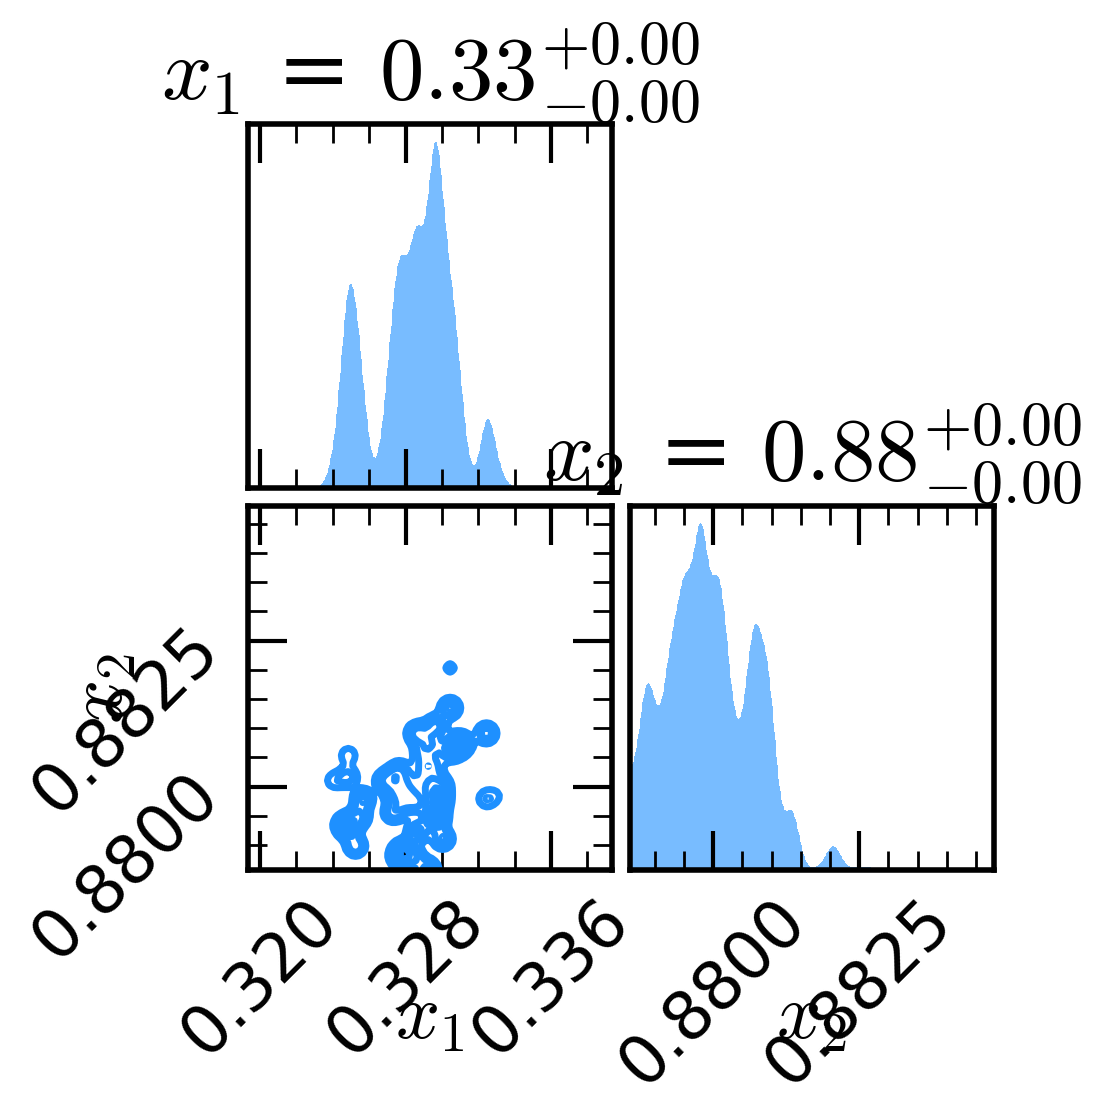

In [220]:
from dynesty import plotting as dyplot

fig, axes = plt.subplots(n_params, n_params, figsize=(5, 5))
axes = axes.reshape((n_params, n_params)) 
fg, ax = dyplot.cornerplot(results, color='dodgerblue', #truths=np.zeros(n_params),
                           truth_color='black', show_titles=True,
                           quantiles=None, max_n_ticks=3,
                           fig=(fig, axes))

#### MCMC for comparison

In [201]:
rng = np.random.default_rng(seed=42)
theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
            for param_name in param_names] for _ in range(n_walkers)])

In [202]:

pk_data = Pk_train_scaled[idx_train_check]

n_threads = 8
start = time.time()
if n_threads>1:
    with Pool(processes=n_threads) as pool:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool,
                                    #args=(Pk_train_scaled[idx_train_check],cov_inv)
                                    )
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
else:
    sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior,
                                #args=(Pk_train_scaled[idx_train_check],cov_inv)
                                )
    _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
end = time.time()

print(f"Time: {end-start} s ({(end-start)/60} min)")


100%|██████████| 1000/1000 [10:17<00:00,  1.62it/s]


Time: 618.5994193553925 s (10.309990322589874 min)


In [208]:
samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True,thin=1)
gc.collect()

15889

In [205]:
samples_emcee.shape

(2128, 2)

### Plot contours

In [81]:
param_label_dict = {'omega_cold': r'$\Omega_\mathrm{m}$',
                'sigma8_cold': r'$\sigma_{8}$',
                'hubble': r'$h$',
                'ns': r'$n_\mathrm{s}$',
                'omega_baryon': r'$\Omega_\mathrm{b}$',}
param_labels = [param_label_dict[param_name] for param_name in param_names]
extents = [dict_bounds[param_name] for param_name in param_names]

In [138]:
samples_dynesty.shape

(140, 2)

In [124]:
moment_network_samples.shape

(1000000, 2)

In [206]:
samples_emcee

array([[0.33077805, 0.88080945],
       [0.32700129, 0.87925591],
       [0.32768054, 0.8789477 ],
       ...,
       [0.33368635, 0.88096453],
       [0.32795673, 0.88043312],
       [0.32813271, 0.87974154]])

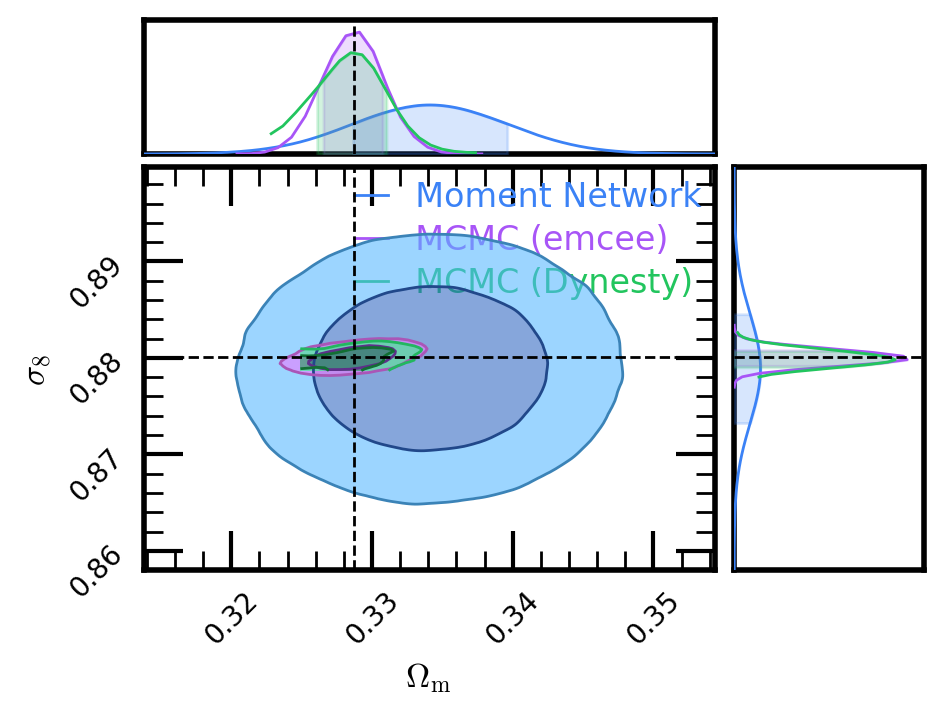

In [236]:
c = chainconsumer.ChainConsumer()

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(moment_network_samples, columns=param_names),
            name='Moment Network', color='blue')
            )

# checked that this gives the same as direct, once remove burn-in
# chain_emcee = chainconsumer.Chain.from_emcee(sampler_emcee, param_names, discard=n_burn,
#                                              name="MCMC (emcee)", color="red")
# c.add_chain(chain_emcee)

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_emcee, columns=param_names),
            name='MCMC (emcee)', color='purple', ls='--',
            smooth=1, bins=10)
            )

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_dynesty, columns=param_names),
            name='MCMC (Dynesty)', color='green', 
            smooth=2, bins=5)
            )

c.set_plot_config(
    chainconsumer.PlotConfig(
        flip=True,
        labels=param_label_dict,
        contour_label_font_size=12,
        #extents=dict_bounds,
    )
)

#c.set_override(chainconsumer.ChainConfig(smooth=1, bins=10))
#c.set_override(chainconsumer.ChainConfig(smooth=1, bins=10))

# c.configure(kde=[1.,None],sigmas = [1,2],
#             contour_label_font_size = 11,
#             label_font_size = 16, shade = False) 

truth_loc = dict(zip(param_names, theta_train_check[0]))
c.add_truth(chainconsumer.Truth(location=truth_loc))

fig = c.plotter.plot(figsize = (5,4) )

### Test on a model from the test set (held-out data)

In [237]:
idx_test = 0
predicted_mean_obs_test = regression.predict(np.atleast_2d(Pk_test_scaled[idx_test]))
predicted_var_obs_test = (regression_var_unknown_mean.predict(np.atleast_2d(Pk_test_scaled[idx_test]))[0])

moment_network_param_cov_test = np.empty((n_params, n_params))
moment_network_param_cov_test[0,0] = predicted_var_obs_test[0]
moment_network_param_cov_test[1,1] = predicted_var_obs_test[1]
moment_network_param_cov_test[0,1] = predicted_var_obs_test[2]
moment_network_param_cov_test[1,0] = predicted_var_obs_test[2]

1/1 [==============================] - 0s 43ms/step


In [238]:
moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                  moment_network_param_cov_test,int(1e6)),dtype=np.float32)
gc.collect()

/tmp/ipykernel_428411/975881696.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],


148069

In [243]:
pk_data = Pk_test_scaled[idx_test]

n_threads = 8

with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:

    sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                    nlive=10, bound='single')
    sampler_test.run_nested(dlogz=0.01)

133it [01:08,  1.95it/s, +10 | bound: 30 | nc: 1 | ncall: 838 | eff(%): 17.271 | loglstar:   -inf < -0.000 <    inf | logz: -8.041 +/-  0.815 | dlogz:  0.001 >  0.010]


In [244]:
results_test = sampler.results
samples_dynesty_test = results.samples_equal()
print(samples_dynesty_test.shape)

(135, 2)


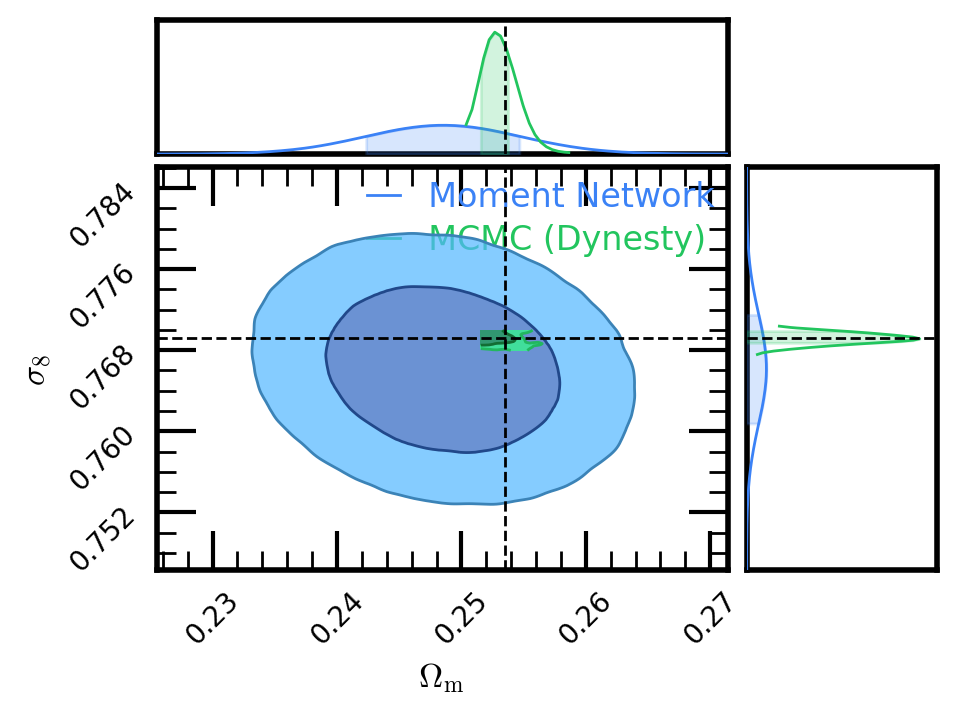

In [245]:
c = chainconsumer.ChainConsumer()

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
            name='Moment Network', color='blue')
            )

# c.add_chain(chainconsumer.Chain(
#             samples=pd.DataFrame(samples_emcee, columns=param_names),
#             name='MCMC (emcee)', color='purple', ls='--',
#             smooth=1, bins=10)
#             )

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
            name='MCMC (Dynesty)', color='green', 
            smooth=2, bins=5)
            )

c.set_plot_config(
    chainconsumer.PlotConfig(
        flip=True,
        labels=param_label_dict,
        contour_label_font_size=12,
        #extents=dict_bounds,
    )
)

truth_loc = dict(zip(param_names, theta_test[idx_test]))
c.add_truth(chainconsumer.Truth(location=truth_loc))

fig = c.plotter.plot(figsize = (5,4) )